选取4个UCI数据集：adult，iris，letter，yeast，除了adult，其余都按60%train，20%validation, 20%test的比例划分

In [1]:
import os
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

## 载入adlut

In [2]:
adult_train = pd.read_csv("../data/adult/adult.csv", na_values = np.nan)
adult_test = pd.read_csv("../data/adult/adult_test.csv", na_values = np.nan)
print("adult_train:", adult_train.shape)
print("adult_test:", adult_test.shape)

adult_train: (30162, 15)
adult_test: (15060, 15)


dataframe转ndarray后, 分离train,test,X,y 

In [3]:
adult_train_X = adult_train.values[:,0:14]
adult_train_y = adult_train.values[:,14:15]
adult_test_X = adult_test.values[:,0:14]
adult_test_y = adult_test.values[:,14:15]
print("adult_train_X:", adult_train_X.shape)
print("adult_train_y:", adult_train_y.shape)
print("adult_test_X:", adult_test_X.shape)
print("adult_test_y:", adult_test_y.shape)

adult_train_X: (30162, 14)
adult_train_y: (30162, 1)
adult_test_X: (15060, 14)
adult_test_y: (15060, 1)


## 载入iris

In [4]:
iris =  pd.read_csv("../data/iris/iris.csv", na_values = np.nan)
print("iris:", iris.shape)

iris: (149, 6)


dataframe转ndarray后, 分离train,test,X,y 

In [5]:
iris_X = iris.values[:,0:4]
iris_y = iris.values[:,4:5]

iris_train_X, iris_test_X, iris_train_y, iris_test_y = train_test_split(iris_X, iris_y, test_size=0.2, 
                                       stratify = iris_y, random_state = 42)
print("iris_train_X:", iris_train_X.shape)
print("iris_train_y:", iris_train_y.shape)
print("iris_test_X:", iris_test_X.shape)
print("iris_test_y:", iris_test_y.shape)

iris_train_X: (119, 4)
iris_train_y: (119, 1)
iris_test_X: (30, 4)
iris_test_y: (30, 1)


## 载入letter

In [6]:
letter =  pd.read_csv("../data/letter/letter.csv", na_values = np.nan)
print("letter:", letter.shape)

letter: (20000, 17)


dataframe转ndarray后, 分离train,test,X,y 

In [7]:
letter_X = letter.values[:,0:4]
letter_y = letter.values[:,4:5]

letter_train_X, letter_test_X, letter_train_y, letter_test_y = train_test_split(letter_X, letter_y, test_size=0.2, 
                                       stratify = letter_y, random_state = 42)
print("letter_train_X:", letter_train_X.shape)
print("letter_train_y:", letter_train_y.shape)
print("letter_test_X:", letter_test_X.shape)
print("letter_test_y:", letter_test_y.shape)

letter_train_X: (16000, 4)
letter_train_y: (16000, 1)
letter_test_X: (4000, 4)
letter_test_y: (4000, 1)


## 载入yeast

In [8]:
yeast =  pd.read_csv("../data/yeast/yeast.csv", na_values = np.nan)
print("yeast:", yeast.shape)

yeast: (1483, 10)


dataframe转ndarray后, 分离train,test,X,y 

In [9]:
yeast_X = yeast.values[:,0:4]
yeast_y = yeast.values[:,4:5]

yeast_train_X, yeast_test_X, yeast_train_y, yeast_test_y = train_test_split(yeast_X, yeast_y, test_size=0.2, 
                                       stratify = yeast_y, random_state = 42)
print("yeast_train_X:", yeast_train_X.shape)
print("yeast_train_y:", yeast_train_y.shape)
print("yeast_test_X:", yeast_test_X.shape)
print("yeast_test_y:", yeast_test_y.shape)

yeast_train_X: (1186, 4)
yeast_train_y: (1186, 1)
yeast_test_X: (297, 4)
yeast_test_y: (297, 1)


## 训练

In [10]:
# function：get_kftrain_proba
# 使用交叉训练，输出整个训练集上所有样本的概率向量

# Input: 
#     X: 总样本
#     y: 总样本
#     model: 某个模型的函数定义
#     cv: 交叉次数
# Output:
#     proba_mat: 训练集所有样本的概率向量

In [22]:
def get_kftrain_proba(X, y, m, cv):
    model_name = m.__class__.__name__
    
    n_samples = X.shape[0] # 总样本数
    n_features = X.shape[1] # 总特征数
    n_class = np.unique(y).shape[0] # 总类别数
    
    proba_mat = np.zeros((n_samples, n_class)) # 输出概率矩阵
    
    index = 0
    skf = StratifiedKFold(n_splits=cv) # 定义k折分层划分器
    
    # 分开训练cv次，训练结果可能不如合并训练好，但能一定程度上减少模型过拟合
    for train_index, test_index in skf.split(X, y):
        K_train_x, K_test_x = X[train_index], X[test_index]
        K_train_y, K_test_y = y[train_index], y[test_index]
        m.fit(K_train_x, K_train_y)
        K_test_y_pred_prob = m.predict_proba(K_test_x)
        
        proba_mat[index:index+K_test_y.shape[0]] = K_test_y_pred_prob
        index += K_test_y.shape[0]
    
    print("Base Acc: %.2f%%" %(accuracy_score(y, np.argmax(proba_mat, axis=1))*100))
    return proba_mat

In [38]:
def trainCE(X, y, models, cv):
    n_samples = X.shape[0] # 总样本数
    n_features = X.shape[1] # 总特征数
    n_class = np.unique(y).shape[0] # 总类别数
    print("n_samples", n_samples)
    print("n_class", n_class)
    
    proba_mat_all = np.zeros((n_samples, n_class)) # 所有模型输出的概率矩阵加权和
    
    n_population = 1000 # 种群数量
    n_elite_population = 100 # 精英种群数量
    max_iteration = 50 # 迭代优化次数
    n_models = len(models)
    weight_mat = np.zeros((n_population, n_models)) # 权重矩阵
    mu = np.zeros(n_models) # 均值数组，初始化为全0
    sigma = np.ones(n_models) # 方差数组，初始化为全1
    
    iterative_weights = np.zeros((max_iteration, n_models)) # 保存了每次迭代选出的最好的参数组
    iterative_scores = np.zeros(max_iteration) # 保存了每次迭代选出的最高分
    
    # 生成各模型的概率矩阵, 存入一个列表
    proba_mat_list = []
    for m in models:
        print(m.__class__.__name__)
        proba_mat = get_kftrain_proba(X, y, m, cv)
        proba_mat_list.append(proba_mat)

    # 各模型的权重优化过程
    for t in range(max_iteration):
        
        n_scores = np.zeros(n_population) # 所有参数组的得分
        weight_mat = np.zeros((n_population, n_models)) # 所有参数组的权重矩阵
        
        elite_scores = np.zeros(n_elite_population) # 精英参数组的得分
        elite_weight_mat = np.zeros((n_elite_population, n_models)) # 精英参数组的权重矩阵
        
        # 生成各参数的种群
        for j in range(n_models):
            
#             w = np.random.normal(mu[j], sigma[j], n_population) # N(0,1)
            w = np.random.normal(mu[j], sigma[j]+700/(t+1), n_population)
            weight_mat[:,j] = w

        # 映射各参数组至区间[0:1]内
        for i in range(n_population):
            w2 = np.zeros(n_models)
            # 遍历第i行所有元素，做映射
            for k in range(n_models):
                w2[k] = np.exp(-weight_mat[i][k]*weight_mat[i][k]) # 映射函数：y=e^(-x^2)
                # w2[k] = np.exp(weight_mat[i][k])/np.sum(np.exp(weight_mat[i]))
            weight_mat[i] = w2
        
        # 计算各参数组目标函数——各参数组的accuracy score
        for i in range(n_population):
            y_pred_ensemble_proba = np.zeros((n_samples, n_class)) # 当前组的加权概率矩阵
            # 各基学习器的概率矩阵 * 权重，求和
            for j in range(n_models):
                y_pred_ensemble_proba += proba_mat_list[j] * weight_mat[i][j]
            y_pred_ensemble = np.argmax(y_pred_ensemble_proba, axis=1) # 转换加权后概率矩阵为预测类别
            acc = accuracy_score(y, y_pred_ensemble)
            # f1 = f1_score(y_valid, y_pred_ensemble, average="weighted")
            n_scores[i] = acc # 所有参数组的得分

        # 排列在前面的精英参数组的下标
        elite_index = np.argsort(-np.array(n_scores))[:n_elite_population]

        # 记录精英参数组
        elite_weight_mat = weight_mat[elite_index] # 精英参数组的权重矩阵
        elite_scores = np.array(n_scores)[elite_index] # 精英参数组的得分
        # print("elite_weight_mat.shape", elite_weight_mat.shape)
        # print("elite_scores.shape", elite_scores.shape)
        # 记录第t次迭代时：最好参数组及对应得分
        iterative_weights[t] = elite_weight_mat[0,:]
        iterative_scores[t] = elite_scores[0]
        
        # 由精英参数组的的分布，更新mu，sigma
        mu = np.mean(elite_weight_mat, axis = 0)
        sigma = np.std(elite_weight_mat, axis = 0)
        
        # print("Iteration: %d, Accuracy %.2f" %(t, iterative_scores[t]*100))
        
    # 权重训练完毕
    print("==================Finish training==================")
    
    print("Best Accuracy in last iteration: %.2f%%" % (iterative_scores[-1]*100))
    print("Weights in last iteration: %s" %(iterative_weights[-1]))

    plt.figure(figsize=(10,6))
    plt.plot(iterative_scores[:50], 'r')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.legend(frameon=False)
    plt.grid(True)
    plt.savefig('../img/CE_iteration.eps',format='eps')
    return iterative_weights[-1]

In [39]:
models = [
    LogisticRegression(),
    LinearDiscriminantAnalysis(),
    SVC(probability=True),
    GaussianNB(),
    KNeighborsClassifier(),
]

n_samples 119
n_class 3
LogisticRegression
Base Acc: 86.55%
LinearDiscriminantAnalysis
Base Acc: 86.55%
SVC
Base Acc: 86.55%
GaussianNB
Base Acc: 83.19%
KNeighborsClassifier
Base Acc: 86.55%


/Users/alex/anaconda/envs/gc/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/alex/anaconda/envs/gc/lib/python3.6/site-packages/ipykernel/__main__.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
No handles with labels found to put in legend.


==================Finish training==================
Best Accuracy in last iteration: 87.39%
Weights in last iteration: [5.42716816e-002 6.75137040e-002 1.00303209e-003 2.29794669e-020
 2.73349451e-201]


array([5.42716816e-002, 6.75137040e-002, 1.00303209e-003, 2.29794669e-020,
       2.73349451e-201])

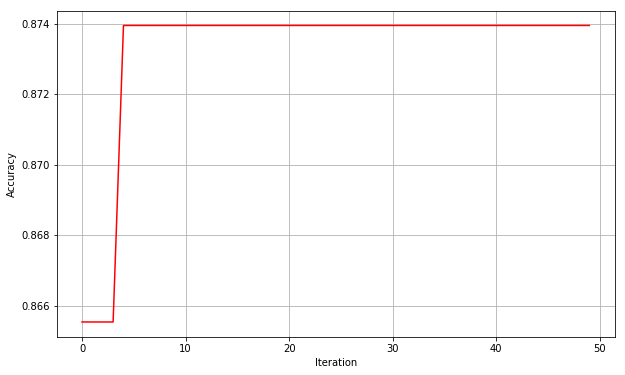

In [40]:
trainCE(iris_train_X, iris_train_y, models, 5)